# 🌳 Simulación de Árbol Galton-Watson con Espina

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------- Muestreos --------
def sample_pk_geometric(rng):
    # pk = 1/2^{k+1}, k>=0  => Geometrica(0.5) - 1
    return rng.geometric(0.5) - 1

def sample_rhok_size_biased(rng):
    # rho_k = k / 2^{k+1}, k>=1  (usamos la funcion de distribucion CDF: F(n)=1-(n+2)/2^{n+1})
    u = rng.random()
    n = 1
    while True:
        if u <= 1 - (n + 2) / (2 ** (n + 1)):
            return n
        n += 1

# -------- Generación del árbol con espina + niveles con orden estable --------
def generate_gw_tree_with_spine_levels(max_profundidad=6, seed=42):
    rng = np.random.default_rng(seed)
    siguiente_id = 0
    nodos = {siguiente_id: {'profundidad': 0, 'espina': True}}; siguiente_id += 1
    aristas = []
    nodos_por_nivel = {0: [0]}      # dict: profundidad -> lista de nodos EN ORDEN
    raiz_actual = 0

    for profundidad in range(max_profundidad):
        # aseguro listas para niveles siguientes
        nodos_por_nivel.setdefault(profundidad+1, [])
        nodos_por_nivel.setdefault(profundidad+2, [])

        # hijos del padre de la espina en este nivel (k ~ rho)
        k_sp = sample_rhok_size_biased(rng)
        hijos_espina = []
        for _ in range(k_sp):
            nid = siguiente_id; siguiente_id += 1
            nodos[nid] = {'profundidad': profundidad+1, 'espina': False}
            aristas.append((raiz_actual, nid))
            hijos_espina.append(nid)
            # *** orden estable: apendo en el orden de creación ***
            nodos_por_nivel[profundidad+1].append(nid)

        # si no hubo hijos, terminamos
        if not hijos_espina:
            break

        # elegimos nuevo padre de la espina y marcamos
        siguiente_raiz = rng.choice(hijos_espina)
        nodos[siguiente_raiz]['espina'] = True

        # los otros hijos generan nietos con pk; quedan contiguos y en orden
        for c in hijos_espina:
            if c == siguiente_raiz:
                continue
            k = sample_pk_geometric(rng)
            for _ in range(k):
                nid = siguiente_id; siguiente_id += 1
                nodos[nid] = {'profundidad': profundidad+2, 'espina': False}
                aristas.append((c, nid))
                nodos_por_nivel[profundidad+2].append(nid)

        raiz_actual = siguiente_raiz

    return nodos, aristas, nodos_por_nivel

# -------- Dibujo sin cruces (por niveles y en orden) --------
def draw_tree_layered_noncross(nodos, aristas, nodos_por_nivel):
    # posición x = índice en la lista ordenada del nivel; y = -profundidad
    pos = {}
    for d in sorted(nodos_por_nivel.keys()):
        for i, nid in enumerate(nodos_por_nivel[d]):
            pos[nid] = (i, -d)

    plt.figure(figsize=(12, 7))
    # aristas (entre niveles consecutivos; sin cruces por construcción)
    for u, v in aristas:
        x1, y1 = pos[u]; x2, y2 = pos[v]
        plt.plot([x1, x2], [y1, y2])

    # nodos (espina en rojo)
    xs, ys, cols = [], [], []
    for nid, (x, y) in pos.items():
        xs.append(x); ys.append(y)
        cols.append('red' if nodos[nid].get('espina', False) else 'lightgray')
    plt.scatter(xs, ys, c=cols, s=300)
    for nid, (x, y) in pos.items():
        plt.text(x, y, str(nid), ha='center', va='center', fontsize=8)

    plt.title("Árbol de Galton–Watson con espina — layout por niveles sin cruces")
    plt.axis('off')
    plt.show()

# ---- Demo
nodos, aristas, nodos_por_nivel = generate_gw_tree_with_spine_levels(max_profundidad=10, seed=7)

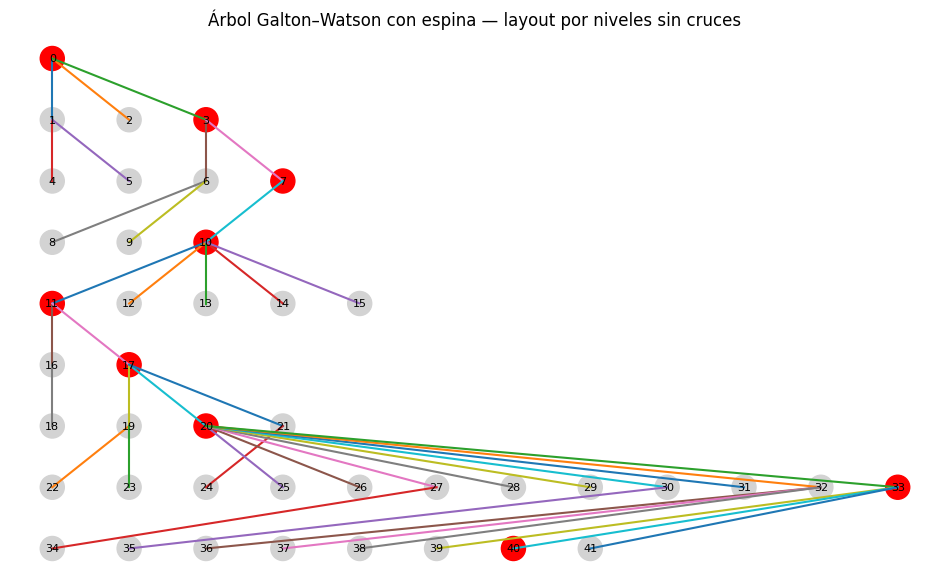

In [ ]:
draw_tree_layered_noncross(nodes, edges, level_nodes)

In [ ]:
!pip install graphviz

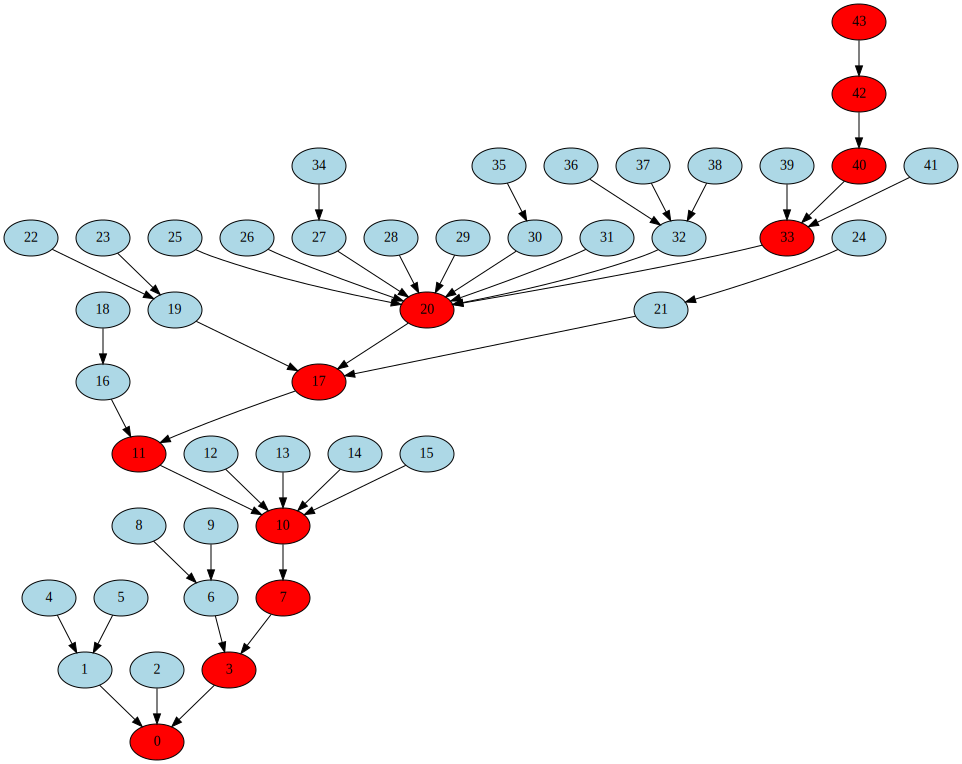

In [ ]:
import graphviz

def draw_tree_graphviz(nodos, aristas, invertir_aristas=False):
    dot = graphviz.Digraph(comment='Árbol de Galton-Watson con Espina', strict=True) # strict=True helps prevent parallel edges

    # Add nodes with color based on spine property
    for nid, data in nodos.items():
        color = 'red' if data.get('espina', False) else 'lightblue'
        dot.node(str(nid), label=str(nid), style='filled', fillcolor=color)

    # Add edges
    for u, v in aristas:
        if invertir_aristas:
            dot.edge(str(v), str(u)) # Reverse the edge direction
        else:
            dot.edge(str(u), str(v))

    # Render the graph
    display(dot)

# Draw the tree using graphviz with reversed edges
draw_tree_graphviz(nodos, aristas, invertir_aristas=True)